# Selection Playbook

Notebook scaffold for ranking assets based on breakout heuristics, on-chain flows, and risk filters.

## TODO
- [ ] Load price, volume, and on-chain snapshots from QuantConnect and CoinGecko datasets.
- [ ] Engineer factor buckets (acceleration, relative volume, whale concentration, social buzz).
- [ ] Assemble composite selection scores, tier assets, and export candidate lists.


## Candidate Data Feeds

### QuantConnect Native
- **Benzinga News / Tiingo News** – headline sentiment and metadata for BTC, ETH, and select large-cap alts; useful for fast event confirmation but thin coverage on long-tail coins.
- **Brain Language Metrics** – relevance/novelty scores derived from global news; can flag macro narratives that bleed into crypto momentum.
- **Quiver Social Sentiment** – Reddit/Twitter aggregates; picks up mainstream retail chatter around flagship tokens and crypto-linked equities.
- **CoinGecko Market Cap (QC dataset)** – market-cap ranks, dominance, turnover stats to support universe sizing and relative-strength filters.

### External Integrations (to stitch in)
- **Santiment / Whale Alerts** – wallet concentration, whale inflows/outflows, crowd sentiment scores for mid-cap alts.
- **LunarCrush / CryptoQuant** – social dominance, exchange reserves, funding metrics across major venues.
- **On-chain Indexers (Glassnode, Nansen, Dune queries)** – active addresses, supply dynamics, staking unlock calendars tailored per chain.
- **Twitter / Reddit Firehose (via third-party APIs)** – custom NLP pipelines for influencer momentum and community buzz on smaller tokens.

### Operational Notes
- Align each dataset with `DataRequestSpec` entries for reproducibility.
- Track licensing/latency tiers (QuantConnect datasets vs. BYO APIs) before wiring into live selection screens.


## Indicator Playbook

### Price & Structure
- Donchian and pivot breakouts, ATR/Keltner width squeezes, multi-horizon momentum tiers.
- VWAP/anchored VWAP drift, mean-reversion z-scores, regime change detectors.

### Volume & Liquidity
- Relative volume percentiles, cumulative volume delta, book imbalance and depth elasticity.
- Venue rotation and stablecoin inflow measures for cross-exchange appetite.

### On-chain Dynamics
- Whale wallet inflows/outflows, active addresses growth, NVT/NVM deviations.
- Exchange reserve delta, staking unlock calendars, supply concentration shifts.

### Sentiment & Behavior
- Headline polarity, social volume acceleration, influencer-trigger alerts.
- Reddit/Twitter NLP scores, Google Trends spikes, crowd fear/greed gauges.

### Derivatives & Funding
- Perp funding rate momentum, basis term-structure kinks, liquidation heatmaps.
- Options IV rank/skew, realized–implied spread alerts.

### Macro & Network Overlays
- Crypto beta vs. DXY/real yields, global liquidity proxies, volatility regime classification.
- Metcalfe-style network valuation residuals, hash-rate versus price divergence checks.

## Combo Ideas
- Breakout confirmation: squeeze + 20/60d momentum + relative volume + whale inflow filter.
- Sentiment spike: NLP delta + social dominance + exchange outflows with liquidity guardrails.
- Whale tracking: large transactions + OBV slope + funding normalization to avoid blow-offs.
- Network value overlay: momentum stack gated by NVT/NVM and active address acceleration.
- Volatility expansion: realized–implied spread + liquidity expansion + network residual drift.
- Macro regime: crypto momentum adjusted by real-rate residuals and stablecoin supply growth.



In [61]:
# %pip install --quiet quantconnect-stubs
from datetime import datetime
from datetime import timedelta
from pathlib import Path
from typing import Iterable

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    from IPython.display import display
except ImportError:  # pragma: no cover - fallback for non-notebook contexts
    display = None

from research.scripts.data_loader import DataLoader, DataRequestSpec
from research.scripts import qc_native_features as qc_feat

pd.options.display.max_columns = 20

try:
    from QuantConnect import Resolution  # type: ignore[import]
    from QuantConnect.Research import QuantBook  # type: ignore[import]
except ImportError as exc:  # pragma: no cover - requires QuantConnect runtime
    raise RuntimeError(
        "QuantConnect Research assemblies not found. Run inside a Lean Research environment."
    ) from exc

try:
    plt.style.use("seaborn-v0_8")
except OSError:  # pragma: no cover - fallback if style unavailable
    plt.style.use("seaborn")

qb = QuantBook()


def enum_to_str(enum_obj) -> str:
    """Return a string representation of a QuantConnect enum."""

    if hasattr(enum_obj, "ToString"):
        return enum_obj.ToString()
    name = getattr(enum_obj, "name", None)
    if name is not None:
        return name
    return str(enum_obj)


def add_crypto_universe(tickers: Iterable[str], resolution: Resolution = Resolution.Hour):
    """Register crypto assets for the research universe and return their Symbol objects."""

    symbols = []
    for ticker in tickers:
        symbol = qb.AddCrypto(ticker, resolution).Symbol
        symbols.append(symbol)
    return symbols


UNIVERSE = ["BTCUSD", "ETHUSD", "SOLUSD"]
DEFAULT_RESOLUTION = Resolution.Hour
SYMBOLS = add_crypto_universe(UNIVERSE, DEFAULT_RESOLUTION)

REQUEST_START = datetime(2024, 1, 1)
REQUEST_END = datetime.utcnow()

loader = DataLoader()
for symbol in SYMBOLS:
    loader.register(
        DataRequestSpec(
            symbol=symbol.Value,
            market=symbol.ID.Market,
            security_type="Crypto",
            resolution=enum_to_str(DEFAULT_RESOLUTION),
            start=REQUEST_START.isoformat(),
            end=REQUEST_END.isoformat(),
        )
    )


In [62]:
DATA_CACHE_ROOT = Path("data")
ONCHAIN_CACHE = DATA_CACHE_ROOT / "onchain"
FUNDING_CACHE = DATA_CACHE_ROOT / "funding"
SENTIMENT_CACHE = DATA_CACHE_ROOT / "sentiment"
DEFI_CACHE = DATA_CACHE_ROOT / "defi"
TOKENOMICS_CACHE = DATA_CACHE_ROOT / "tokenomics"
EXECUTION_CACHE = DATA_CACHE_ROOT / "execution"


def load_cached_timeseries(file_path: Path, index_col: str = "timestamp") -> pd.DataFrame | None:
    """Load a cached time-series dataset if present; return None when absent."""

    if not file_path.exists():
        return None

    if file_path.suffix == ".parquet":
        df = pd.read_parquet(file_path)
    else:
        df = pd.read_csv(file_path)

    if index_col in df.columns:
        df[index_col] = pd.to_datetime(df[index_col])
        df = df.set_index(index_col)
    df = df.sort_index()
    return df



In [63]:
FEATURE_LOOKBACK = timedelta(days=90)
ROC_WINDOWS = (24, 72, 168)
NORM_MOM_WINDOW = 72
LIQUIDITY_LOOKBACK = 10
FEATURE_CACHE = DATA_CACHE_ROOT / "native_features"

FEATURE_FRAMES: dict[str, pd.DataFrame] = {}

price_history = qb.History(SYMBOLS, FEATURE_LOOKBACK, DEFAULT_RESOLUTION)
if price_history.empty:
    raise ValueError("History request returned empty frame. Check data permissions or timeframe.")

closes = price_history.close.unstack(level=0).tz_localize(None)
highs = price_history.high.unstack(level=0).tz_localize(None)
lows = price_history.low.unstack(level=0).tz_localize(None)
volumes = price_history.volume.unstack(level=0).tz_localize(None)

for symbol in SYMBOLS:
    symbol_key = symbol.Value
    price = closes[symbol_key].dropna()
    high = highs[symbol_key].reindex(price.index)
    low = lows[symbol_key].reindex(price.index)
    volume = volumes[symbol_key].reindex(price.index)

    roc_features = qc_feat.multi_horizon_roc(price, ROC_WINDOWS)
    norm_mom = qc_feat.normalized_momentum(price, window=24, vol_window=NORM_MOM_WINDOW)
    atr_pct = qc_feat.atr_percent(high, low, price)
    liquidity = qc_feat.liquidity_metrics(price, volume, lookback=LIQUIDITY_LOOKBACK)

    feature_frame = pd.concat([roc_features, norm_mom, atr_pct, liquidity], axis=1).dropna()
    FEATURE_FRAMES[symbol_key] = feature_frame

if display is not None:
    preview = {key: df.tail(5) for key, df in FEATURE_FRAMES.items()}
    display(preview)
else:
    print({key: df.tail(5) for key, df in FEATURE_FRAMES.items()})


{'BTCUSD':                       roc_24h   roc_72h  roc_168h  normalized_mom_24_72  \
 time                                                                      
 2025-11-16 01:00:00  0.004996 -0.061972 -0.061082              0.225482   
 2025-11-16 02:00:00 -0.000576 -0.063175 -0.063401             -0.025854   
 2025-11-16 03:00:00 -0.008726 -0.063733 -0.059713             -0.391476   
 2025-11-16 04:00:00 -0.008314 -0.064259 -0.059986             -0.372566   
 2025-11-16 05:00:00 -0.005238 -0.064104 -0.060503             -0.234143   
 
                      atr_percent  liquidity_score_10  
 time                                                  
 2025-11-16 01:00:00     0.005615        1.473324e+09  
 2025-11-16 02:00:00     0.005250        1.505353e+09  
 2025-11-16 03:00:00     0.004852        1.285757e+09  
 2025-11-16 04:00:00     0.004643        1.273466e+09  
 2025-11-16 05:00:00     0.004475        6.232825e+08  ,
 'ETHUSD':                       roc_24h   roc_72h  roc_168h  n

In [64]:
FEATURE_CACHE.mkdir(parents=True, exist_ok=True)
for symbol_key, frame in FEATURE_FRAMES.items():
    cache_file = FEATURE_CACHE / f"{symbol_key.lower()}_native_features.parquet"
    frame.to_parquet(cache_file)


In [65]:
def zscore(series: pd.Series) -> float:
    values = series.dropna()
    if values.empty or values.std() == 0:
        return 0.0
    return ((values.iloc[-1] - values.mean()) / values.std()).item()

COMPOSITE_ROWS = []
for symbol_key, frame in FEATURE_FRAMES.items():
    latest = frame.iloc[-1]
    momentum_stack = latest[[f"roc_{w}h" for w in ROC_WINDOWS]].mean()
    normalized_mom = latest[[col for col in frame.columns if col.startswith("normalized_mom")]].mean()
    volatility_penalty = -latest.get("atr_percent", 0)
    liquidity_score = latest[[col for col in frame.columns if col.startswith("liquidity_score")]].mean()

    component_scores = {
        "symbol": symbol_key,
        "momentum_stack": momentum_stack,
        "normalized_momentum": normalized_mom,
        "volatility_penalty": volatility_penalty,
        "liquidity": liquidity_score,
    }
    COMPOSITE_ROWS.append(component_scores)

COMPOSITE_FRAME = pd.DataFrame(COMPOSITE_ROWS).set_index("symbol")
COMPOSITE_FRAME["selection_score"] = (
    COMPOSITE_FRAME["momentum_stack"].rank(pct=True)
    + COMPOSITE_FRAME["normalized_momentum"].rank(pct=True)
    + COMPOSITE_FRAME["liquidity"].rank(pct=True)
    + COMPOSITE_FRAME["volatility_penalty"].rank(pct=True)
) / 4

COMPOSITE_FRAME.sort_values("selection_score", ascending=False)


,momentum_stack,normalized_momentum,volatility_penalty,liquidity,selection_score
symbol,,,,,
BTCUSD,-0.043282,-0.234143,-0.004475,6.232825e+08,0.916667
ETHUSD,-0.051031,-0.032345,-0.007093,1.419814e+08,0.750000
SOLUSD,-0.075682,-0.574295,-0.008972,5.278650e+07,0.333333


In [66]:
TOP_N = 10
composite_sorted = COMPOSITE_FRAME.sort_values("selection_score", ascending=False)
summary_table = composite_sorted.head(TOP_N)
summary_table


,momentum_stack,normalized_momentum,volatility_penalty,liquidity,selection_score
symbol,,,,,
BTCUSD,-0.043282,-0.234143,-0.004475,6.232825e+08,0.916667
ETHUSD,-0.051031,-0.032345,-0.007093,1.419814e+08,0.750000
SOLUSD,-0.075682,-0.574295,-0.008972,5.278650e+07,0.333333


In [67]:
analysis_timestamp = closes.index[-1].tz_localize("UTC") if closes.index.tz is None else closes.index[-1]
selection_log_path = FEATURE_CACHE / "selection_log.parquet"
universe_log_path = FEATURE_CACHE / "universe_log.parquet"

log_frame = COMPOSITE_FRAME.reset_index().rename(columns={"index": "symbol"})
log_frame.insert(0, "date", pd.to_datetime(analysis_timestamp))
log_frame["selected"] = log_frame["symbol"].isin(summary_table.index)

for path, frame in [
    (selection_log_path, log_frame.loc[log_frame["selected"]]),
    (universe_log_path, log_frame),
]:
    if frame.empty:
        continue
    frame = frame.reset_index(drop=True)
    if path.exists():
        existing = pd.read_parquet(path)
        combined = pd.concat([existing, frame], axis=0, ignore_index=True)
        combined = combined.drop_duplicates(subset=["date", "symbol"], keep="last")
    else:
        combined = frame
    combined.to_parquet(path, index=False)


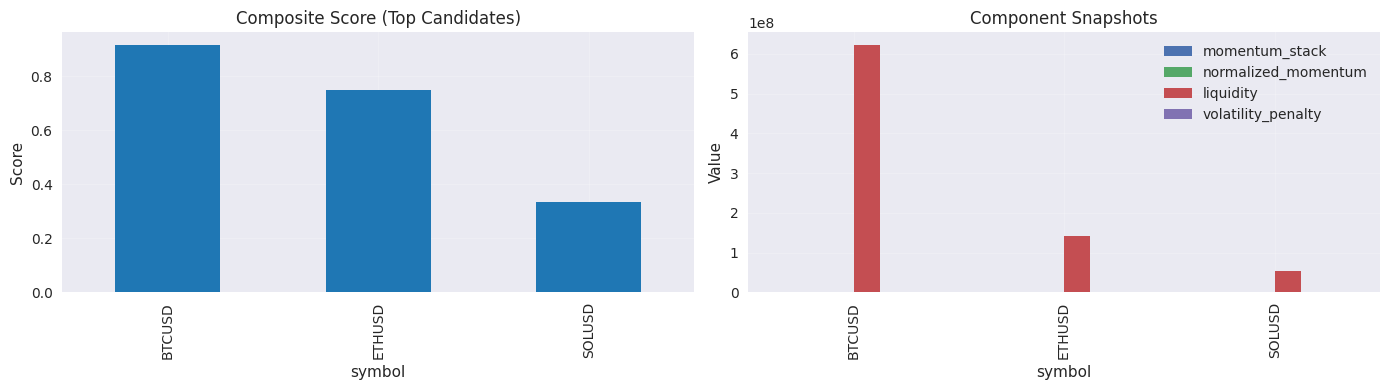

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
summary_table["selection_score"].plot.bar(ax=axes[0], color="tab:blue")
axes[0].set_title("Composite Score (Top Candidates)")
axes[0].set_ylabel("Score")
axes[0].grid(alpha=0.2)

component_cols = ["momentum_stack", "normalized_momentum", "liquidity", "volatility_penalty"]
summary_table[component_cols].plot.bar(ax=axes[1])
axes[1].set_title("Component Snapshots")
axes[1].set_ylabel("Value")
axes[1].grid(alpha=0.2)
axes[1].legend(loc="upper right")

fig.tight_layout()
plt.show()


- **Momentum Stack**: average of multi-horizon ROC windows; highlights sustained breakouts.
- **Normalized Momentum**: momentum scaled by realized vol; rewards efficient moves.
- **Volatility Penalty**: inverse of ATR%; heavily negative scores indicate erratic trading conditions.
- **Liquidity Score**: uses median dollar volume vs. price range to ensure tradability.

We can iterate on weights/thresholds and add sentiment or macro overlays once the native pipelines are staged.


### Composite Score Preview
The table above ranks the current QC-native universe using a first-pass score built from multi-horizon momentum, normalized momentum vs. volatility, liquidity, and an ATR-based penalty. Higher scores represent stronger, liquid candidates worthy of shortlist consideration. In future iterations we’ll expand this composite to include the native news/sentiment feeds and macro regime overlays documented in `selection_qc_native.ipynb`.


In [69]:
RUN_DATA_PIPELINES = False
PIPELINE_SYMBOLS = [symbol.Value if hasattr(symbol, "Value") else str(symbol) for symbol in SYMBOLS]
PIPELINE_SYMBOLS = [sym.upper() for sym in PIPELINE_SYMBOLS]
RUN_ONCHAIN_PIPELINE = False
RUN_FUNDING_PIPELINE = False
RUN_SENTIMENT_PIPELINE = False
RUN_DEFI_PIPELINE = False
DEFI_PROTOCOL_MAP: dict[str, str] = {}
RUN_TOKENOMICS_PIPELINE = False
RUN_EXECUTION_PIPELINE = False
OVERWRITE_PIPELINE_DATA = False

if RUN_DATA_PIPELINES:
    from research.scripts.data_fetchers import (
        onchain as onchain_fetcher,
        funding as funding_fetcher,
        sentiment as sentiment_fetcher,
        defi as defi_fetcher,
        tokenomics as tokenomics_fetcher,
        execution as execution_fetcher,
    )

    pipeline_reports = {}

    if RUN_ONCHAIN_PIPELINE:
        pipeline_reports["onchain"] = onchain_fetcher.run_pipeline(
            PIPELINE_SYMBOLS,
            ONCHAIN_CACHE,
            overwrite=OVERWRITE_PIPELINE_DATA,
        )

    if RUN_FUNDING_PIPELINE:
        pipeline_reports["funding"] = funding_fetcher.run_pipeline(
            PIPELINE_SYMBOLS,
            FUNDING_CACHE,
            overwrite=OVERWRITE_PIPELINE_DATA,
        )

    if RUN_SENTIMENT_PIPELINE:
        pipeline_reports["sentiment"] = sentiment_fetcher.run_pipeline(
            PIPELINE_SYMBOLS,
            SENTIMENT_CACHE,
            overwrite=OVERWRITE_PIPELINE_DATA,
        )

    if RUN_DEFI_PIPELINE:
        protocol_map = {symbol: DEFI_PROTOCOL_MAP.get(symbol, symbol.lower()) for symbol in PIPELINE_SYMBOLS}
        pipeline_reports["defi"] = defi_fetcher.run_pipeline(
            PIPELINE_SYMBOLS,
            protocol_map=protocol_map,
            out_dir=DEFI_CACHE,
            overwrite=OVERWRITE_PIPELINE_DATA,
        )

    if RUN_TOKENOMICS_PIPELINE:
        pipeline_reports["tokenomics"] = tokenomics_fetcher.run_pipeline(
            PIPELINE_SYMBOLS,
            TOKENOMICS_CACHE,
            overwrite=OVERWRITE_PIPELINE_DATA,
        )

    if RUN_EXECUTION_PIPELINE:
        pipeline_reports["execution"] = execution_fetcher.run_pipeline(
            overwrite=OVERWRITE_PIPELINE_DATA,
        )

    if pipeline_reports:
        summary = {key: list(value.values()) if isinstance(value, dict) else value for key, value in pipeline_reports.items()}
        if display is not None:
            display(summary)
        else:
            print(summary)



## Data Coverage Audit

### Core Market Data
- **Spot OHLCV (minute/second/tick)** — *QuantConnect native* via standard `History`/live subscriptions across crypto, FX, equities, futures.
- **Order book depth (L2/L3)** — *External*; source from exchange websockets or vendors (Kaiko, CoinAPI), stream into Lean with custom data classes.
- **Corporate actions (equities)** — *QuantConnect native* through Security Master; keep for cross-asset filters.
- **Crypto exchange coverage** — *QuantConnect native* (Binance/US, Bitfinex, Bybit, Coinbase, Kraken). Extend with custom connectors if needed.

### Liquidity & Trading Frictions
- **Spreads & realized spreads, slippage proxies** — *Derived* from QC quote ticks; implement Kyle lambda/kappa offline.
- **Fee schedules, withdrawal limits, maintenance windows** — *External*; maintain YAML/DB updated from exchange APIs.

### Momentum / Volatility / Microstructure
- **Price momentum, trend filters, breakout stats** — *QuantConnect native* indicator library (Momentum, EMA, ATR, etc.).
- **Volume analytics (RVOL, seasonal baselines)** — *Derived* from QC volume; store transforms in feature registry.
- **Volatility estimators (ATR, GK, realized/IV)** — *QuantConnect native* for ATR & equity IV; crypto options IV needs *external* feeds (Deribit, Amberdata).
- **Microstructure features (trade-sign, book imbalance, reversion)** — *External* tick/L2 ingestion required.

### Derivatives & Leverage (Crypto)
- **Perp funding, open interest, basis, liquidations** — *External* via exchange REST (Binance/Bybit) or aggregators (Coinalyze, CoinGlass).
- **Options surface (IV level/skew, term structure)** — *QuantConnect native* for equity options; crypto options require *external* sources (Deribit, GreeksLive).

### On-chain Metrics
- **Network activity (addresses, fees, hash rate, staking)** — *External* (Glassnode, CoinMetrics, Dune, Nansen).
- **Supply & cohorts (MVRV, SOPR, age bands)** — *External* via same providers; schedule ETL to preserved Parquet.
- **Whale activity & exchange flows** — *External* (Santiment, Whale Alert, CryptoQuant).
- **Tokenomics calendars (unlock, burns, governance)** — *External* (TokenUnlocks, Messari).

### Social / News / Sentiment
- **News headlines + NLP** — *QuantConnect native* (Benzinga, Tiingo); limited altcoin depth.
- **Social signals (Twitter, Reddit, Telegram)** — *External* (Santiment, LunarCrush, custom firehoses).
- **Search trends (Google Trends)** — *External* via PyTrends or vendor.
- **Developer activity (GitHub metrics)** — *External* (Token Terminal, GitHub API).
- **Alt sentiment (Brain metrics)** — *QuantConnect native* for equities; use for regime context.

### Fundamental / Macro
- **Crypto market-cap ranks & dominance** — *QuantConnect native* CoinGecko dataset.
- **Macro releases (rates, inflation, liquidity)** — *QuantConnect native* (EODHD econ/macro feeds) plus optional external calendars.
- **Flows & positioning (ETF creations, stablecoin issuance)** — *External* (Farside, issuer APIs).
- **Sector/theme tags (AI, DeFi, RWA, memecoins)** — *External* taxonomy + NLP classification.

### Universe & Eligibility
- **Tradability filters (turnover, price bounds, venue lists)** — *Derived* in Lean universe selection.
- **Market-cap tiers** — *QuantConnect native* (CoinGecko) + custom rules.
- **Symbol mapping / survivorship handling** — equities handled natively; crypto mapping is *external* (maintain cross-venue IDs).

### Risk Model & Regimes
- **Correlations, betas, clustering** — *Derived* from price history (HRP/graph clustering offline).
- **Factor proxies (momentum, carry, size, quality, value)** — momentum/carry from QC data; quality/value require on-chain inputs -> *external*.
- **Regime labels (trend/liquidity/volatility states)** — *Derived* using price & macro feeds.

### Calendars & Events
- **Protocol roadmaps, forks, upgrades** — *External* (project blogs, Messari).
- **Listings/delistings, maintenance** — *External* (exchange status endpoints).
- **Token unlocks/airdrops** — *External* (TokenUnlocks, VestLab).
- **Legal/regulatory events** — *External* (NLP on filings/news).

### Execution Support
- **Venue selection metrics (spreads, rejects, latency)** — *Derived* from live trading telemetry; store in analytics DB.
- **Borrow & funding availability** — *External* (prime brokers, exchange APIs).

### Additional Enhancements
- **DeFi & yield metrics (TVL, APY, peg deviation)** — *External* (DefiLlama, Messari) for rotation & stress detection.
- **Cross-chain flows (bridge volumes, wrapped supply)** — *External* (Wormhole, LayerZero stats, Nansen).
- **Custody/counterparty risk (PoR, sanctions)** — *External* monitoring feeds.
- **Security alerts (smart-contract exploits)** — *External* (CertiK, BlockSec) feeding risk breakers.
- **Futures curve aggregation (CME vs offshore)** — *Hybrid*; CME via QC futures, offshore basis external.
- **Stablecoin internals (issuer reserves, velocity)** — *External* issuer reports + on-chain data.
- **Alternative engagement (Discord/YouTube)** — *External* scrapers + NLP.
- **TCA/latency footprints** — *Derived* nightly analyses of execution logs.

### Integration Game Plan
1. Tag every feed with `DataRequestSpec` metadata (source, cadence, licensing) for reproducibility.
2. For external datasets, implement Lean custom data classes (`BaseData`) and schedule ETL (REST, websockets, or offline batch).
3. Store normalized outputs (Parquet/S3) and promote reusable loaders into `research/scripts`.
4. Validate new datasets in the `selection_booming_assets` and `selection_risk_controls` notebooks before rolling into live algos.



## Exploratory Snapshots

Flip the switches below to grab and visualize recent history for any subset of `SYMBOLS`. Each block focuses on a different feature family so we can sanity-check distributions before wiring them into selection signals. Additional sections cover volatility/drawdowns and cross-asset structure so we can iterate quickly once new datasets land.


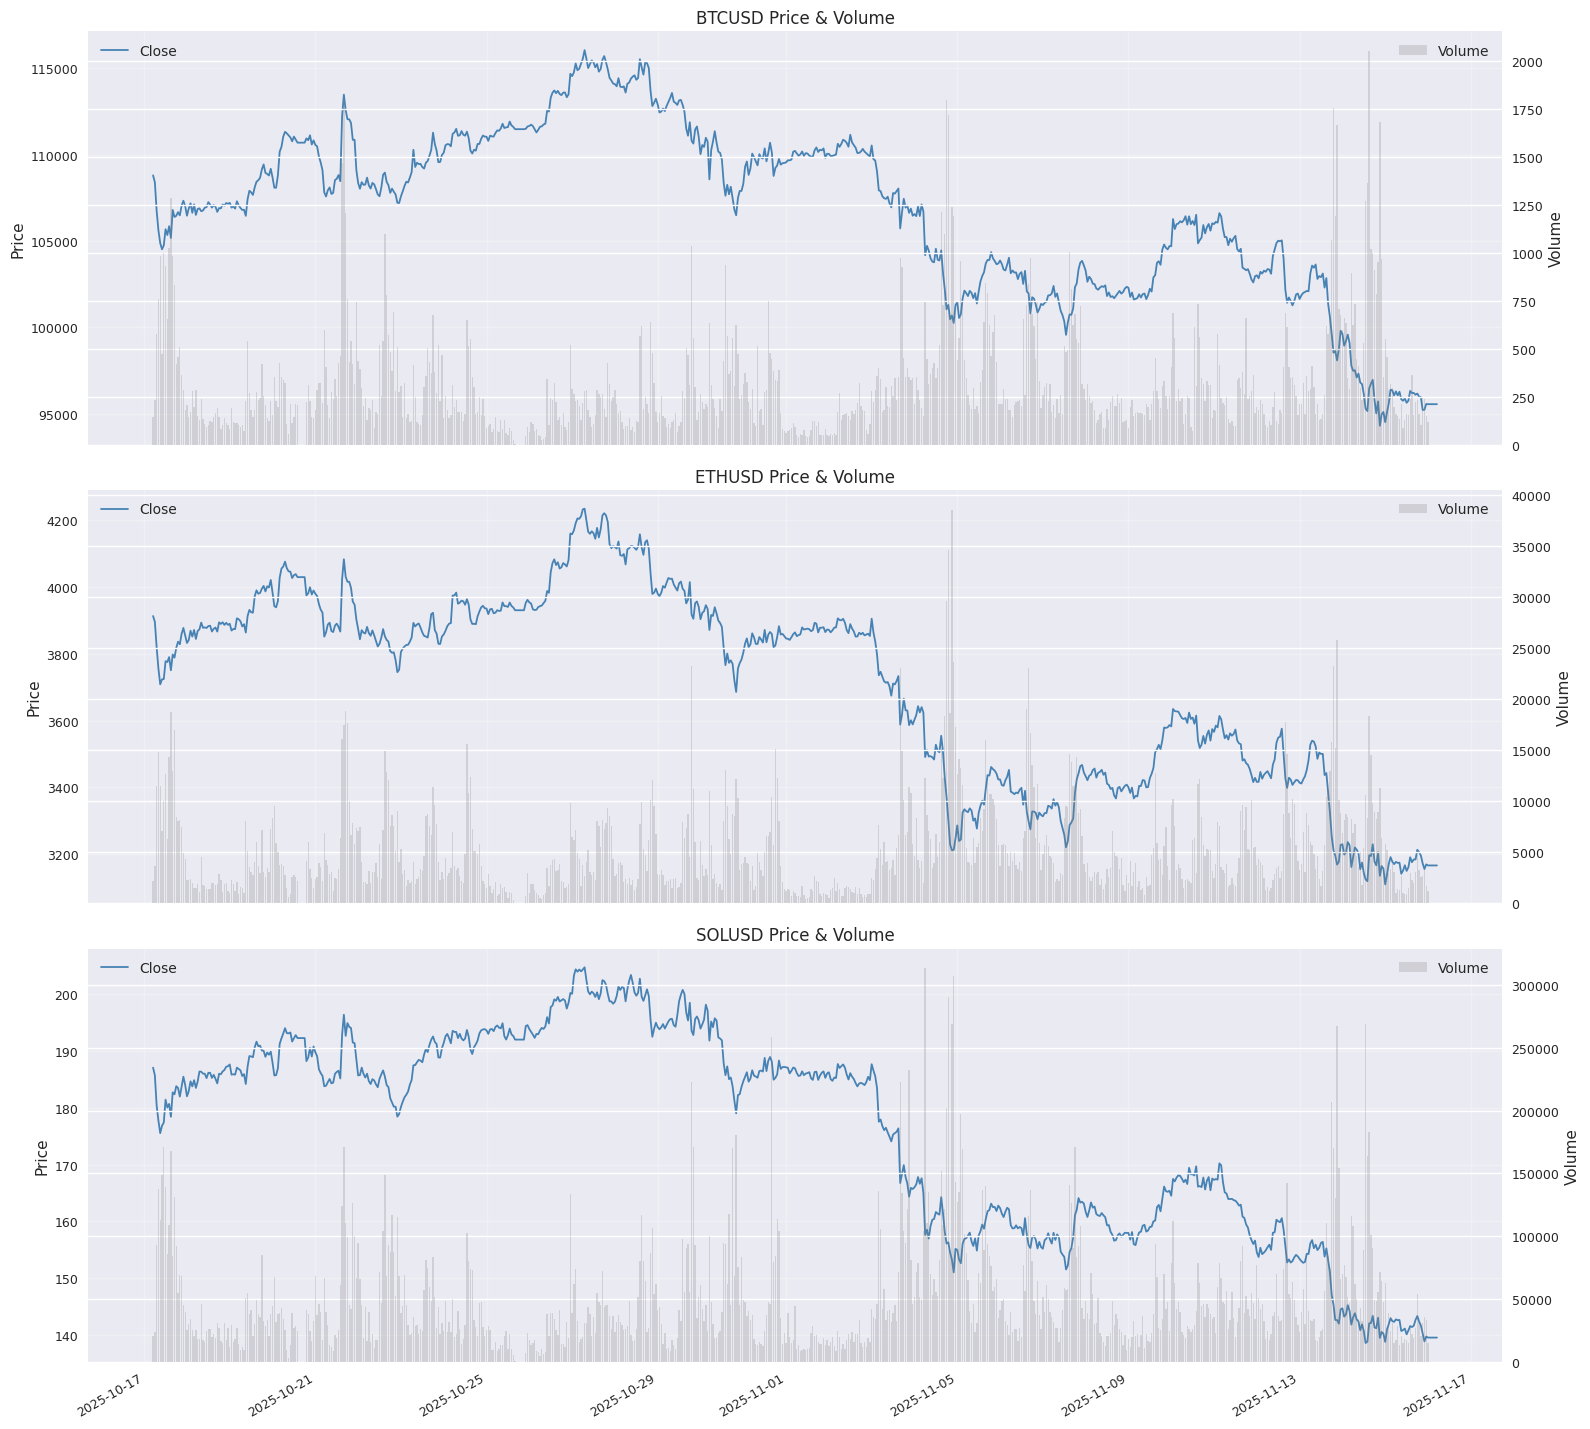

In [70]:
VISUALIZE_PRICE_VOLUME = True
PLOT_LOOKBACK = timedelta(days=30)
PLOT_SYMBOLS = SYMBOLS

if VISUALIZE_PRICE_VOLUME:
    history = qb.History(PLOT_SYMBOLS, PLOT_LOOKBACK, DEFAULT_RESOLUTION)
    if history.empty:
        raise ValueError("History request returned empty frame. Check data permissions or timeframe.")

    closes = history.close.unstack(level=0).tz_localize(None)
    volumes = history.volume.unstack(level=0).tz_localize(None)

    fig, axes = plt.subplots(len(PLOT_SYMBOLS), 1, figsize=(16, 4.8 * len(PLOT_SYMBOLS)), sharex=True)
    if len(PLOT_SYMBOLS) == 1:
        axes = [axes]

    for ax, symbol in zip(axes, PLOT_SYMBOLS):
        symbol_key = symbol.Value
        price_series = closes[symbol_key]
        volume_series = volumes[symbol_key]

        ax.plot(price_series.index, price_series, color="steelblue", linewidth=1.3, label="Close")
        ax.set_ylabel("Price")
        ax.set_title(f"{symbol_key} Price & Volume")
        ax.legend(loc="upper left")
        ax.grid(alpha=0.25)
        ax.tick_params(axis="both", labelsize=9)

        ax2 = ax.twinx()
        if len(volume_series) > 1:
            bar_width = (mdates.date2num(volume_series.index[1]) - mdates.date2num(volume_series.index[0])) * 0.75
        else:
            bar_width = 0.03
        ax2.bar(volume_series.index, volume_series, width=bar_width, color="gray", alpha=0.25, label="Volume")
        ax2.set_ylabel("Volume")
        ax2.legend(loc="upper right")
        ax2.tick_params(axis="both", labelsize=9)

    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()



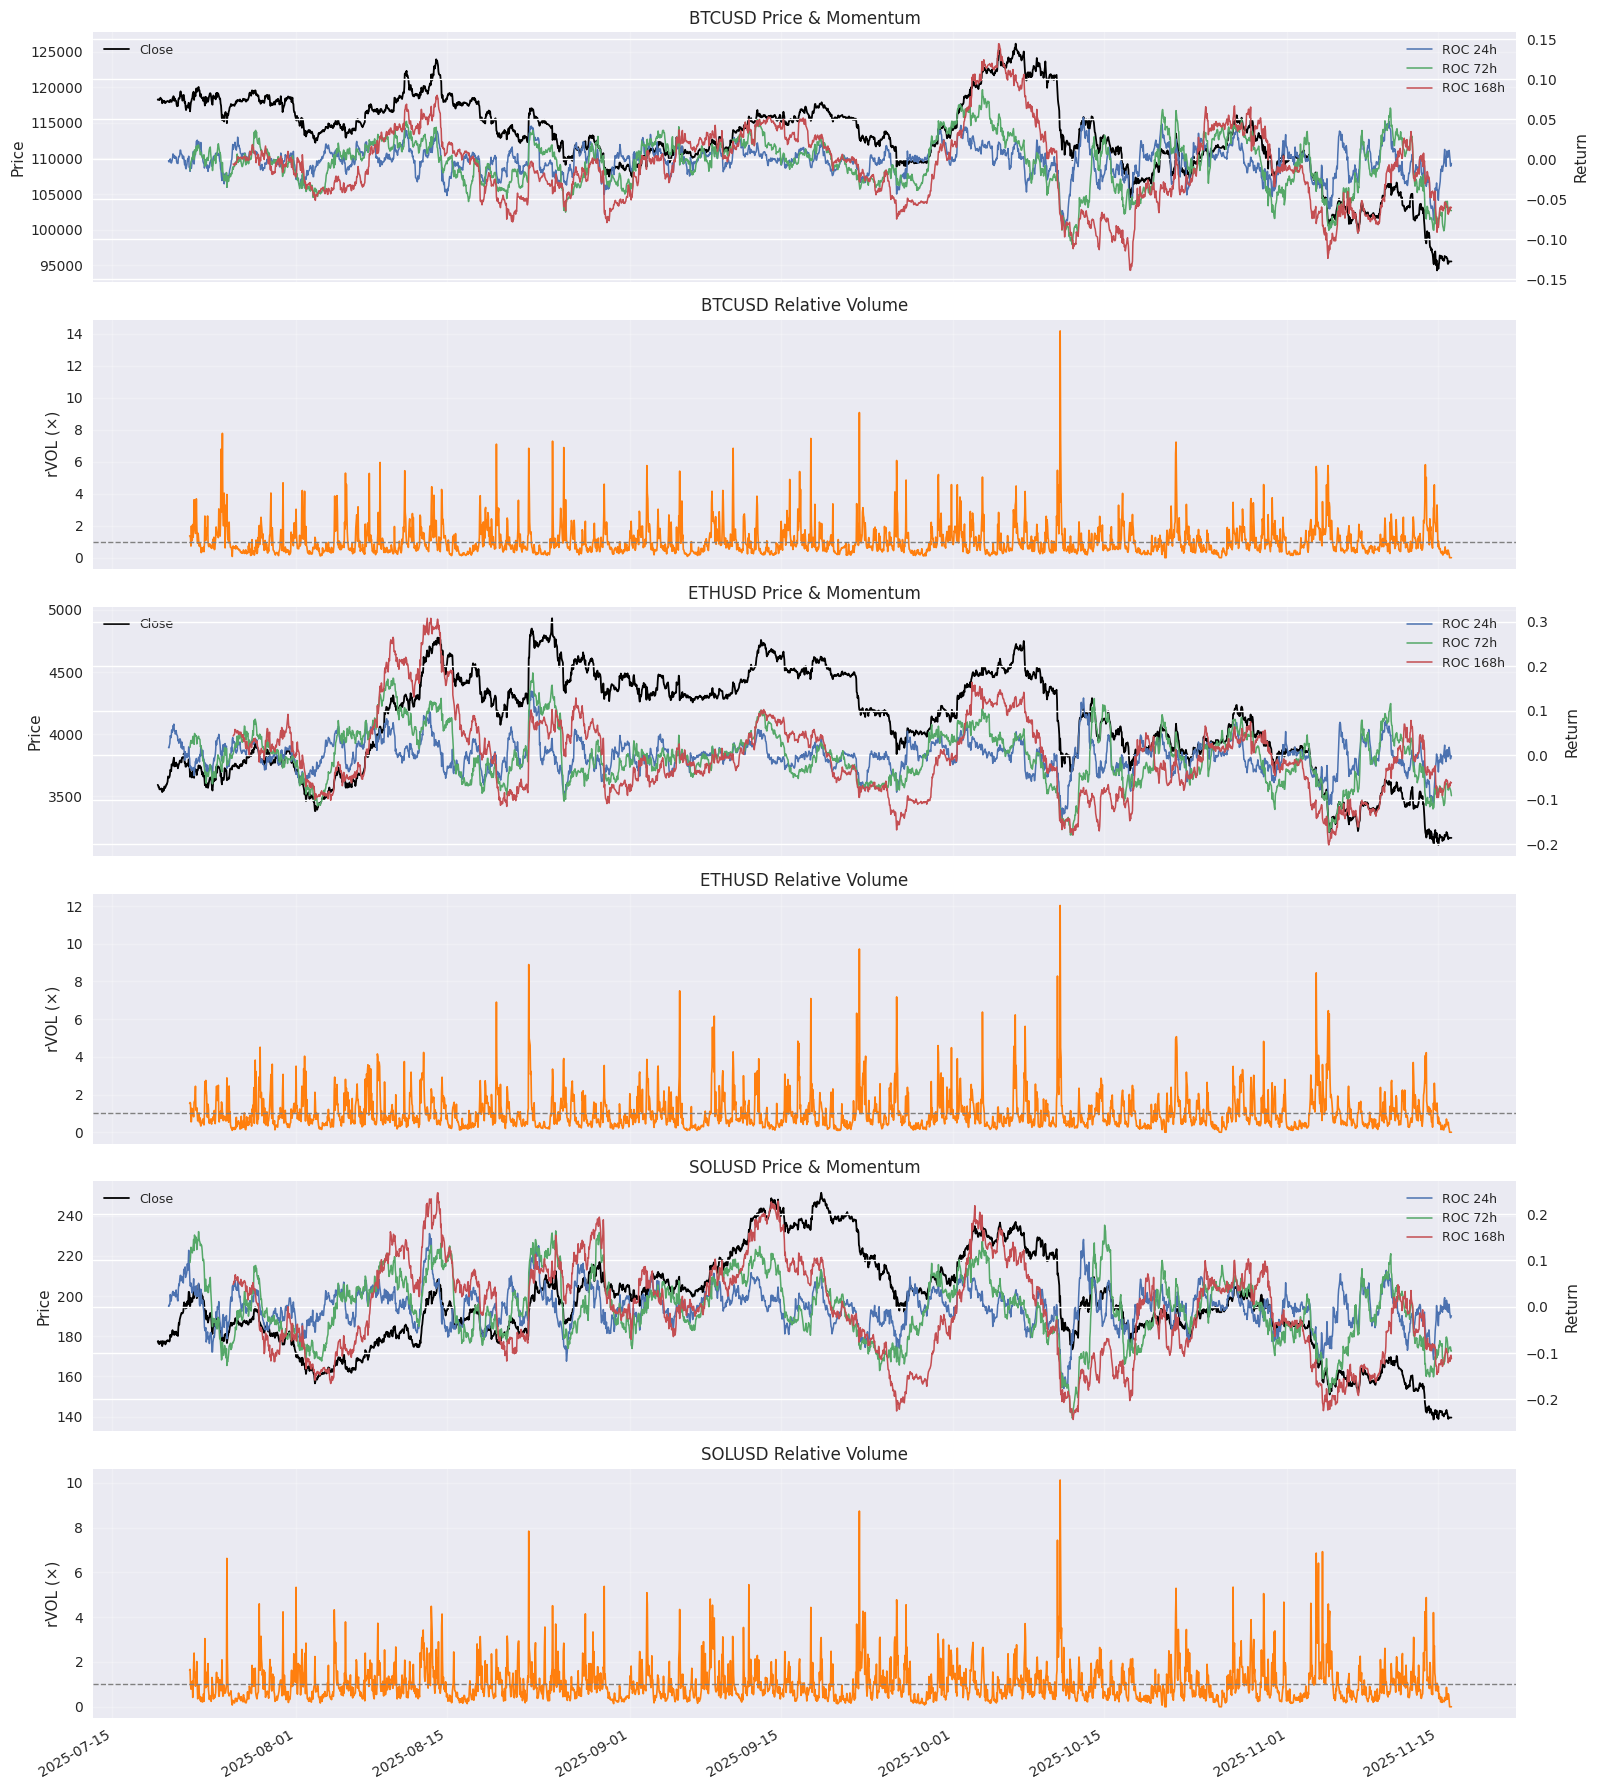

In [71]:
VISUALIZE_MOMENTUM_FACTORS = True
MOM_LOOKBACK = timedelta(days=120)
MOM_WINDOWS = (24, 72, 168)  # hours
RVOL_WINDOW = 72  # hours

if VISUALIZE_MOMENTUM_FACTORS:
    history = qb.History(PLOT_SYMBOLS, MOM_LOOKBACK, DEFAULT_RESOLUTION)
    if history.empty:
        raise ValueError("History request returned empty frame. Check data permissions or timeframe.")

    closes = history.close.unstack(level=0).tz_localize(None)
    volumes = history.volume.unstack(level=0).tz_localize(None)

    rows = len(PLOT_SYMBOLS) * 2
    fig, axes = plt.subplots(rows, 1, figsize=(16, 6.0 * len(PLOT_SYMBOLS)), sharex=True)
    if rows == 1:
        axes = [axes]

    for idx, symbol in enumerate(PLOT_SYMBOLS):
        price_ax = axes[2 * idx]
        rvol_ax = axes[2 * idx + 1]

        symbol_key = symbol.Value
        price_series = closes[symbol_key]
        price_ax.plot(price_series.index, price_series, color="black", linewidth=1.3, label="Close")

        momentum_ax = price_ax.twinx()
        for window in MOM_WINDOWS:
            momentum = price_series.pct_change(window)
            momentum_ax.plot(momentum.index, momentum, linewidth=1.1, label=f"ROC {window}h")
        price_ax.set_ylabel("Price")
        price_ax.set_title(f"{symbol_key} Price & Momentum")
        price_ax.legend(loc="upper left", fontsize=9)
        momentum_ax.set_ylabel("Return")
        momentum_ax.legend(loc="upper right", fontsize=9)
        price_ax.grid(alpha=0.25)
        price_ax.tick_params(axis="both", labelsize=10)
        momentum_ax.tick_params(axis="both", labelsize=10)

        rvol_series = volumes[symbol_key] / volumes[symbol_key].rolling(RVOL_WINDOW).mean()
        rvol_ax.plot(rvol_series.index, rvol_series, color="tab:orange", linewidth=1.2)
        rvol_ax.axhline(1.0, color="gray", linestyle="--", linewidth=1.0)
        rvol_ax.set_ylabel("rVOL (×)")
        rvol_ax.set_title(f"{symbol_key} Relative Volume")
        rvol_ax.grid(alpha=0.25)
        rvol_ax.tick_params(axis="both", labelsize=10)

    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()



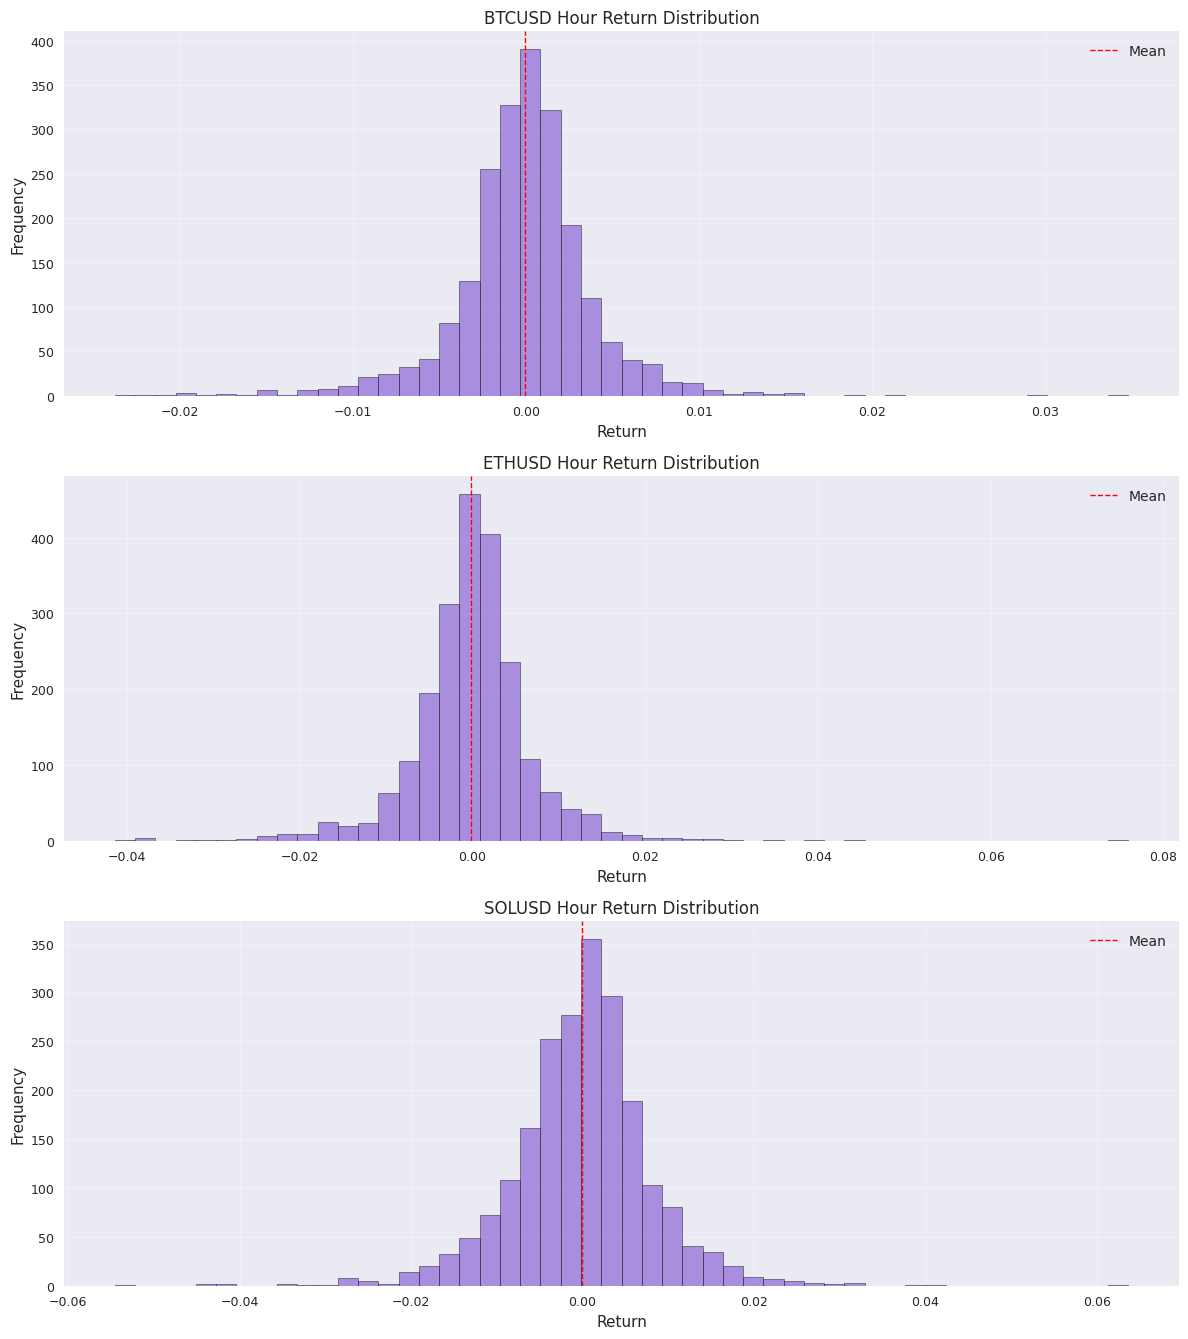

In [72]:
VISUALIZE_RETURN_DISTRIBUTIONS = True
RET_LOOKBACK = timedelta(days=90)
RET_RESOLUTION = Resolution.Hour

if VISUALIZE_RETURN_DISTRIBUTIONS:
    history = qb.History(PLOT_SYMBOLS, RET_LOOKBACK, RET_RESOLUTION)
    if history.empty:
        raise ValueError("History request returned empty frame. Check data permissions or timeframe.")

    closes = history.close.unstack(level=0).tz_localize(None)
    returns = closes.pct_change().dropna()

    fig, axes = plt.subplots(len(PLOT_SYMBOLS), 1, figsize=(12, 4.5 * len(PLOT_SYMBOLS)))
    if len(PLOT_SYMBOLS) == 1:
        axes = [axes]

    resolution_label = enum_to_str(RET_RESOLUTION)

    for ax, symbol in zip(axes, PLOT_SYMBOLS):
        symbol_key = symbol.Value
        data = returns[symbol_key].dropna()
        ax.hist(data, bins=50, alpha=0.75, color="mediumpurple", edgecolor="black", linewidth=0.4)
        ax.axvline(data.mean(), color="red", linestyle="--", linewidth=1, label="Mean")
        ax.set_title(f"{symbol_key} {resolution_label} Return Distribution")
        ax.set_xlabel("Return")
        ax.set_ylabel("Frequency")
        ax.legend()
        ax.grid(alpha=0.25)
        ax.tick_params(axis="both", labelsize=9)

    fig.tight_layout()
    plt.show()



### Volatility & Drawdown Diagnostics
Use these panels to gauge risk signature: rolling realized volatility (multiple horizons), ATR as a percent of price, and max drawdown depth. Helpful for spotting regime shifts and sizing constraints before ranking assets.


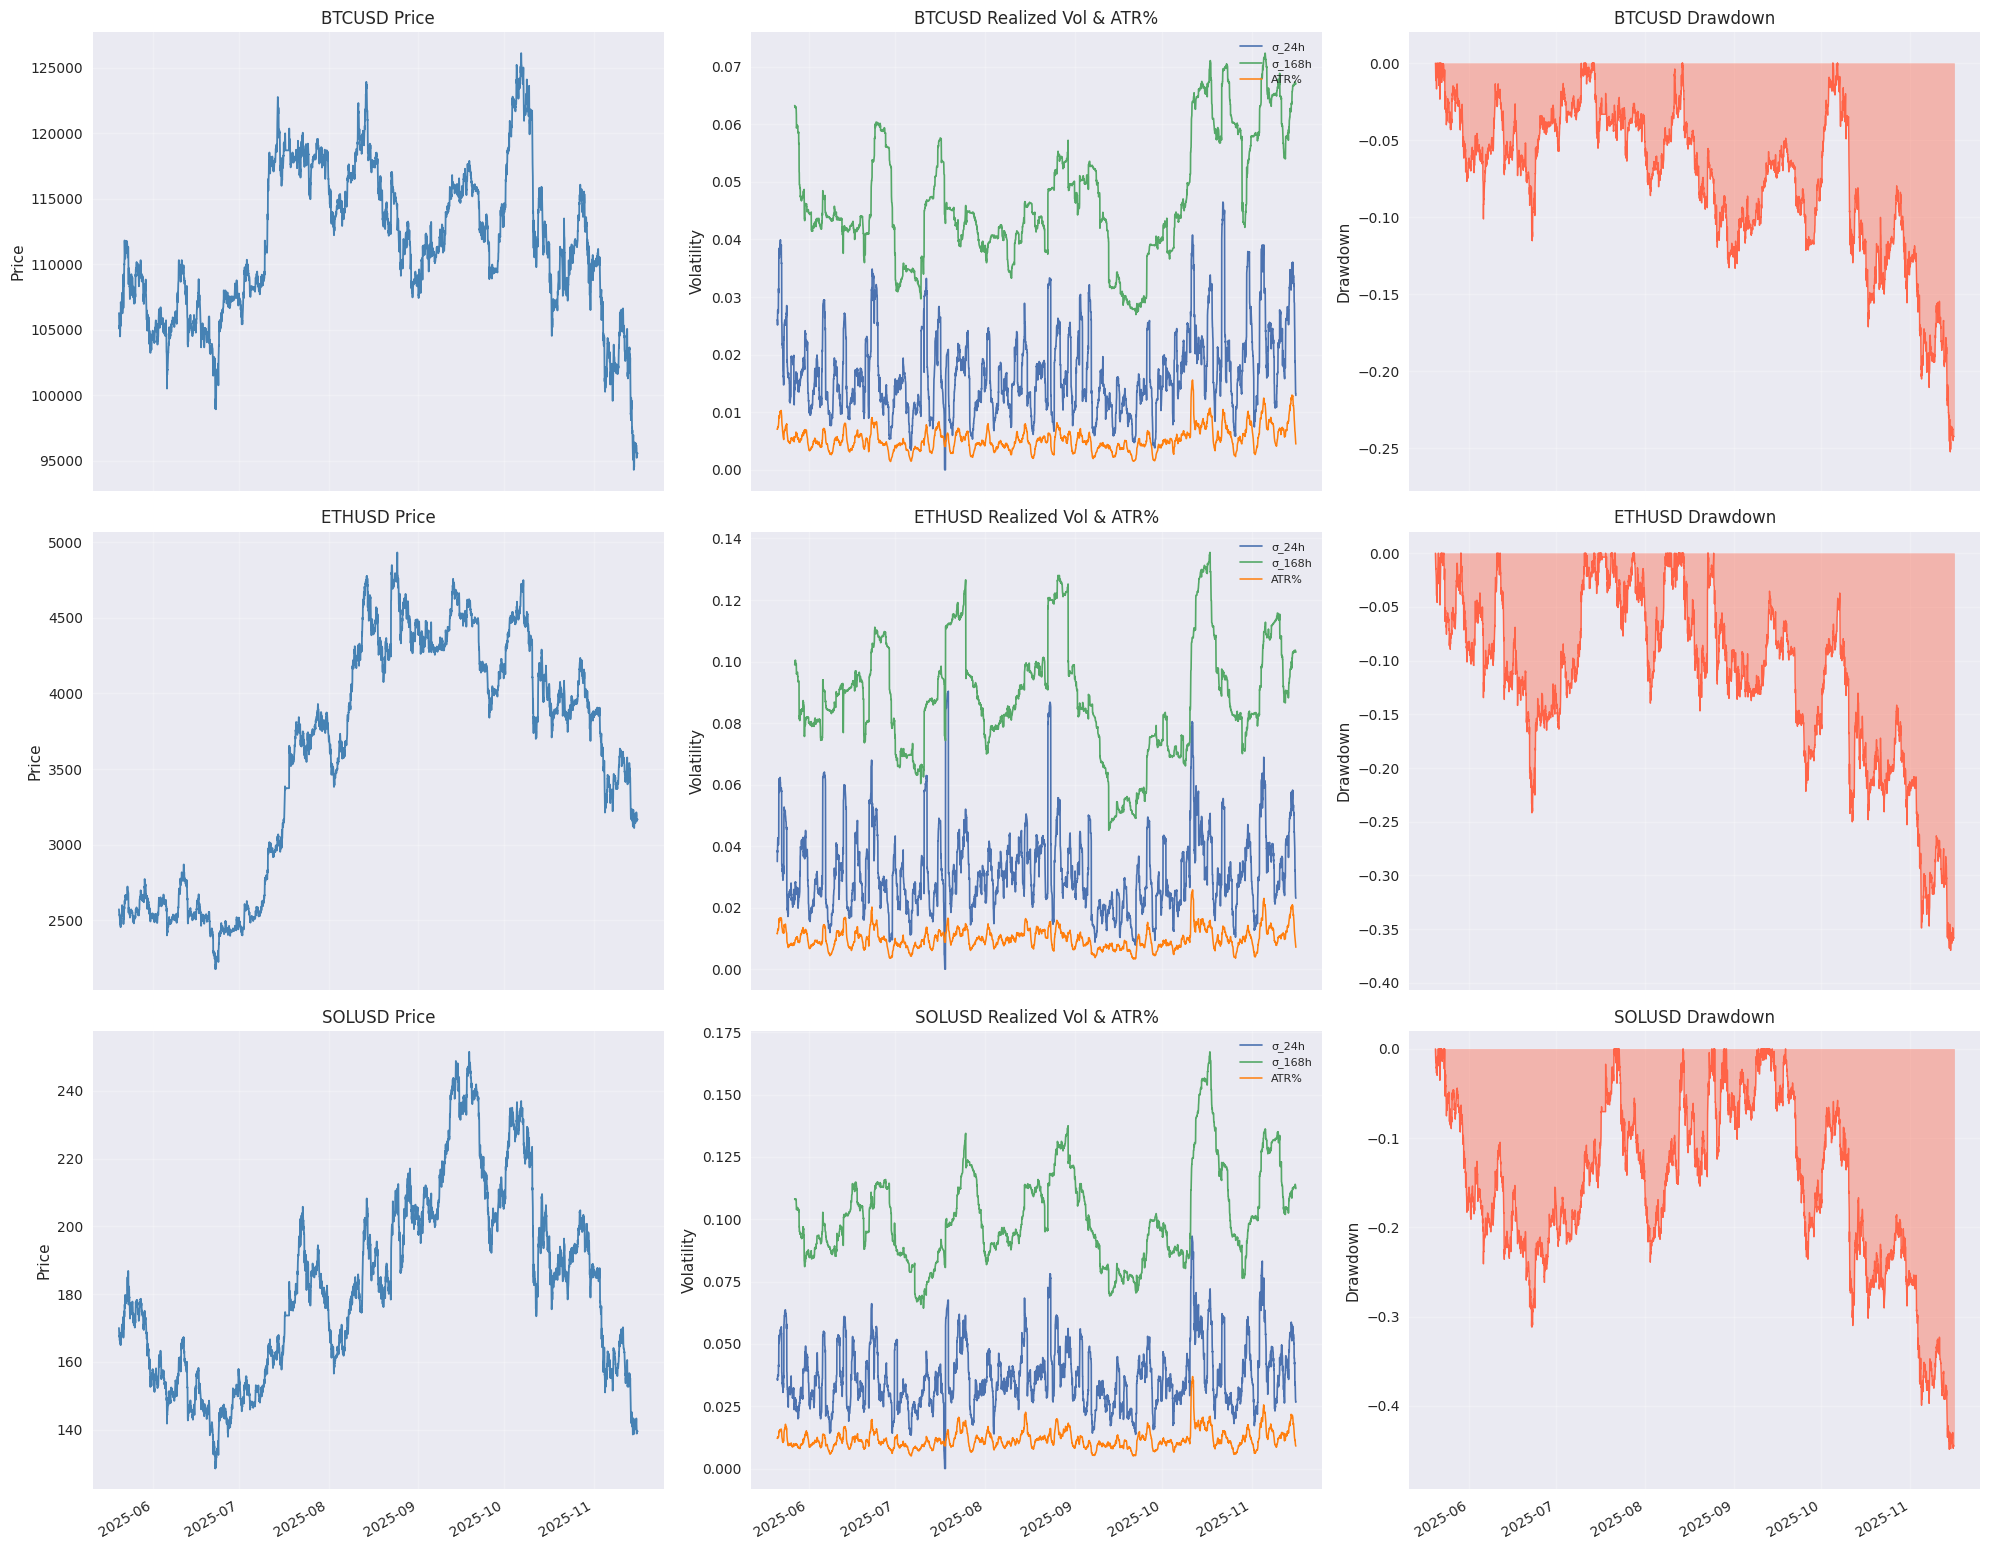

In [73]:
VISUALIZE_VOL_RISK = True
VOL_LOOKBACK = timedelta(days=180)
REALIZED_WINDOWS = (24, 168)
ATR_WINDOW = 24

if VISUALIZE_VOL_RISK:
    history = qb.History(PLOT_SYMBOLS, VOL_LOOKBACK, DEFAULT_RESOLUTION)
    if history.empty:
        raise ValueError("History request returned empty frame. Check data permissions or timeframe.")

    closes = history.close.unstack(level=0).tz_localize(None)
    highs = history.high.unstack(level=0).tz_localize(None)
    lows = history.low.unstack(level=0).tz_localize(None)
    returns = closes.pct_change().dropna()

    fig, axes = plt.subplots(len(PLOT_SYMBOLS), 3, figsize=(20, 5.2 * len(PLOT_SYMBOLS)), sharex='col')
    if len(PLOT_SYMBOLS) == 1:
        axes = [axes]

    for row_axes, symbol in zip(axes, PLOT_SYMBOLS):
        price_ax, vol_ax, dd_ax = row_axes
        symbol_key = symbol.Value
        price_series = closes[symbol_key].dropna()
        high_series = highs[symbol_key].dropna()
        low_series = lows[symbol_key].dropna()
        ret_series = returns[symbol_key].dropna()

        price_ax.plot(price_series.index, price_series, color='steelblue', linewidth=1.3)
        price_ax.set_title(f"{symbol_key} Price")
        price_ax.set_ylabel("Price")
        price_ax.grid(alpha=0.25)
        price_ax.tick_params(axis='both', labelsize=10)

        for window in REALIZED_WINDOWS:
            realized = ret_series.rolling(window).std() * np.sqrt(window)
            vol_ax.plot(realized.index, realized, linewidth=1.2, label=f"σ_{window}h")
        true_range = pd.concat([
            (high_series - low_series),
            (high_series - price_series.shift(1)).abs(),
            (low_series - price_series.shift(1)).abs()
        ], axis=1).max(axis=1)
        atr = true_range.rolling(ATR_WINDOW).mean()
        atr_pct = (atr / price_series).rename('ATR%')
        vol_ax.plot(atr_pct.index, atr_pct, color='tab:orange', linewidth=1.1, label='ATR%')
        vol_ax.set_title(f"{symbol_key} Realized Vol & ATR%")
        vol_ax.set_ylabel("Volatility")
        vol_ax.legend(loc='upper right', fontsize=8)
        vol_ax.grid(alpha=0.25)
        vol_ax.tick_params(axis='both', labelsize=10)

        rolling_max = price_series.cummax()
        drawdown = price_series / rolling_max - 1
        dd_ax.fill_between(drawdown.index, drawdown, 0, color='tomato', alpha=0.4)
        dd_ax.plot(drawdown.index, drawdown, color='tomato', linewidth=1.0)
        dd_ax.set_title(f"{symbol_key} Drawdown")
        dd_ax.set_ylabel("Drawdown")
        dd_ax.grid(alpha=0.25)
        dd_ax.tick_params(axis='both', labelsize=10)
        dd_ax.set_ylim(min(drawdown.min() * 1.1, -0.05), 0.02)

    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()



### Cross-Asset Structure
Correlation and co-movement diagnostics help us understand diversification and shared drivers across the candidate universe. These panels will grow as we add macro and sentiment overlays.


### On-Chain Activity
Visual inspection of on-chain flow helps validate whether capital is entering or leaving venues. Plug in Glassnode/CoinMetrics/Nansen extracts (saved under `data/onchain/`) to light up active addresses, exchange netflows, and whale transactions.


In [74]:
VISUALIZE_ONCHAIN = False
ONCHAIN_FIELDS = [
    ("active_addresses", "Active Addresses"),
    ("exchange_netflow", "Exchange Netflow"),
    ("whale_tx_usd", "Whale Tx Volume (USD)")
]

if VISUALIZE_ONCHAIN:
    available = []
    missing = []
    for symbol in PLOT_SYMBOLS:
        symbol_key = symbol.Value
        cache_file = ONCHAIN_CACHE / f"{symbol_key.lower()}_onchain.parquet"
        df = load_cached_timeseries(cache_file)
        if df is None or df.empty:
            missing.append(symbol_key)
            continue
        available.append((symbol_key, df))

    if missing:
        print(f"Missing on-chain cache for: {', '.join(missing)}")

    if not available:
        raise FileNotFoundError(
            "No on-chain cache located. Populate data/onchain/<symbol>_onchain.parquet via your ETL pipeline."
        )

    fig, axes = plt.subplots(len(available), len(ONCHAIN_FIELDS), figsize=(20, 5 * len(available)), sharex='col')
    axes = np.atleast_2d(axes)

    for row_axes, (symbol_key, df) in zip(axes, available):
        for ax, (field, title) in zip(row_axes, ONCHAIN_FIELDS):
            if field not in df.columns:
                ax.text(0.5, 0.5, f"Field '{field}' not found", ha='center', va='center', fontsize=10)
                ax.set_axis_off()
                continue
            series = df[field].dropna()
            if series.empty:
                ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=10)
                ax.set_axis_off()
                continue
            ax.plot(series.index, series, linewidth=1.2, color='teal')
            ax.set_title(f"{symbol_key} {title}")
            ax.grid(alpha=0.25)
            ax.tick_params(axis='both', labelsize=9)

    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()



### Funding & Derivatives
Hook in Coinalyze/CoinGlass/Deribit extracts under `data/funding/` to monitor perp funding regimes, open-interest builds, and spot-perp basis moves before we commit capital.


In [75]:
VISUALIZE_FUNDING = False
FUNDING_FIELDS = [
    ("funding_rate", "Funding Rate (%)"),
    ("open_interest_usd", "Open Interest (USD)"),
    ("basis_pct", "Spot-Perp Basis (%)")
]

if VISUALIZE_FUNDING:
    available = []
    missing = []
    for symbol in PLOT_SYMBOLS:
        symbol_key = symbol.Value
        cache_file = FUNDING_CACHE / f"{symbol_key.lower()}_funding.parquet"
        df = load_cached_timeseries(cache_file)
        if df is None or df.empty:
            missing.append(symbol_key)
            continue
        available.append((symbol_key, df))

    if missing:
        print(f"Missing funding cache for: {', '.join(missing)}")

    if not available:
        raise FileNotFoundError(
            "No funding cache located. Populate data/funding/<symbol>_funding.parquet via your ETL pipeline."
        )

    fig, axes = plt.subplots(len(available), len(FUNDING_FIELDS), figsize=(20, 5 * len(available)), sharex='col')
    axes = np.atleast_2d(axes)

    for row_axes, (symbol_key, df) in zip(axes, available):
        for ax, (field, title) in zip(row_axes, FUNDING_FIELDS):
            if field not in df.columns:
                ax.text(0.5, 0.5, f"Field '{field}' not found", ha='center', va='center', fontsize=10)
                ax.set_axis_off()
                continue
            series = df[field].dropna()
            if series.empty:
                ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=10)
                ax.set_axis_off()
                continue
            ax.plot(series.index, series, linewidth=1.2, color='slateblue')
            ax.set_title(f"{symbol_key} {title}")
            ax.grid(alpha=0.25)
            ax.tick_params(axis='both', labelsize=9)

    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()



### Sentiment & Attention
Drop Santiment/LunarCrush/Twitter aggregates into `data/sentiment/` to inspect social dominance, polarity, and mention velocity alongside price action.


In [76]:
VISUALIZE_SENTIMENT = False
SENTIMENT_FIELDS = [
    ("social_dominance", "Social Dominance (%)"),
    ("sentiment_score", "Sentiment Score"),
    ("mention_velocity", "Mention Velocity")
]

if VISUALIZE_SENTIMENT:
    available = []
    missing = []
    for symbol in PLOT_SYMBOLS:
        symbol_key = symbol.Value
        cache_file = SENTIMENT_CACHE / f"{symbol_key.lower()}_sentiment.parquet"
        df = load_cached_timeseries(cache_file)
        if df is None or df.empty:
            missing.append(symbol_key)
            continue
        available.append((symbol_key, df))

    if missing:
        print(f"Missing sentiment cache for: {', '.join(missing)}")

    if not available:
        raise FileNotFoundError(
            "No sentiment cache located. Populate data/sentiment/<symbol>_sentiment.parquet via your ETL pipeline."
        )

    fig, axes = plt.subplots(len(available), len(SENTIMENT_FIELDS), figsize=(20, 5 * len(available)), sharex='col')
    axes = np.atleast_2d(axes)

    for row_axes, (symbol_key, df) in zip(axes, available):
        for ax, (field, title) in zip(row_axes, SENTIMENT_FIELDS):
            if field not in df.columns:
                ax.text(0.5, 0.5, f"Field '{field}' not found", ha='center', va='center', fontsize=10)
                ax.set_axis_off()
                continue
            series = df[field].dropna()
            if series.empty:
                ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=10)
                ax.set_axis_off()
                continue
            ax.plot(series.index, series, linewidth=1.2, color='seagreen')
            ax.set_title(f"{symbol_key} {title}")
            ax.grid(alpha=0.25)
            ax.tick_params(axis='both', labelsize=9)

    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()



### DeFi & Liquidity
Cached DefiLlama/Messari pulls under `data/defi/` (pool TVL, borrow/supply rates, liquidity fragmentation) make it easy to see whether on-chain liquidity is following our breakout candidates.


In [77]:
VISUALIZE_DEFI = False
DEFI_FIELDS = [
    ("tvl_usd", "TVL (USD)"),
    ("borrow_rate", "Borrow Rate (%)"),
    ("supply_rate", "Supply Rate (%)")
]

if VISUALIZE_DEFI:
    available = []
    missing = []
    for symbol in PLOT_SYMBOLS:
        symbol_key = symbol.Value
        cache_file = DEFI_CACHE / f"{symbol_key.lower()}_defi.parquet"
        df = load_cached_timeseries(cache_file)
        if df is None or df.empty:
            missing.append(symbol_key)
            continue
        available.append((symbol_key, df))

    if missing:
        print(f"Missing DeFi cache for: {', '.join(missing)}")

    if not available:
        raise FileNotFoundError(
            "No DeFi cache located. Populate data/defi/<symbol>_defi.parquet via your ETL pipeline."
        )

    fig, axes = plt.subplots(len(available), len(DEFI_FIELDS), figsize=(20, 5 * len(available)), sharex='col')
    axes = np.atleast_2d(axes)

    for row_axes, (symbol_key, df) in zip(axes, available):
        for ax, (field, title) in zip(row_axes, DEFI_FIELDS):
            if field not in df.columns:
                ax.text(0.5, 0.5, f"Field '{field}' not found", ha='center', va='center', fontsize=10)
                ax.set_axis_off()
                continue
            series = df[field].dropna()
            if series.empty:
                ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=10)
                ax.set_axis_off()
                continue
            ax.plot(series.index, series, linewidth=1.2, color='darkorange')
            ax.set_title(f"{symbol_key} {title}")
            ax.grid(alpha=0.25)
            ax.tick_params(axis='both', labelsize=9)

    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()



### Tokenomics & Events
Store unlock/burn/governance schedules under `data/tokenomics/` to surface upcoming supply shocks that may impact the selection list.


In [78]:
VISUALIZE_TOKENOMICS = False
TOKEN_EVENT_FILES = (
    "_events.parquet",
    "_events.csv"
)

if VISUALIZE_TOKENOMICS:
    missing = []
    for symbol in PLOT_SYMBOLS:
        symbol_key = symbol.Value
        dataset = None
        for suffix in TOKEN_EVENT_FILES:
            candidate = TOKENOMICS_CACHE / f"{symbol_key.lower()}{suffix}"
            if candidate.exists():
                if candidate.suffix == ".parquet":
                    dataset = pd.read_parquet(candidate)
                else:
                    dataset = pd.read_csv(candidate)
                break
        if dataset is None or dataset.empty:
            missing.append(symbol_key)
            continue

        date_cols = [
            col for col in ("event_time", "start_time", "end_time", "start", "end")
            if col in dataset.columns
        ]
        for col in date_cols:
            dataset[col] = pd.to_datetime(dataset[col])
        dataset = dataset.sort_values(date_cols[0] if date_cols else dataset.columns[0])

        print(f"Tokenomics timeline for {symbol_key}")
        columns_to_show = [col for col in dataset.columns if col not in {"details", "notes"}]
        preview = dataset[columns_to_show].head(10)
        if display is not None:
            display(preview)
        else:
            print(preview.to_string(index=False))
        print("\n")

    if missing and len(missing) == len(PLOT_SYMBOLS):
        raise FileNotFoundError(
            "No tokenomics schedules found. Populate data/tokenomics/<symbol>_events.(csv|parquet)."
        )
    elif missing:
        print(f"Missing tokenomics schedules for: {', '.join(missing)}")



### Execution Analytics
After running paper/live algos, export venue fill logs under `data/execution/` so we can review slippage, latency, and fill efficiency before promoting selection ideas into production.


In [79]:
VISUALIZE_EXECUTION = False
EXECUTION_METRICS_FILE = EXECUTION_CACHE / "execution_metrics.parquet"

if VISUALIZE_EXECUTION:
    metrics = load_cached_timeseries(EXECUTION_METRICS_FILE, index_col="timestamp")
    if metrics is None or metrics.empty:
        raise FileNotFoundError(
            "No execution metrics found. Populate data/execution/execution_metrics.parquet with fill logs."
        )

    if "symbol" not in metrics.columns:
        raise ValueError("Execution metrics file must include a 'symbol' column.")

    metrics.index = pd.to_datetime(metrics.index)
    metrics = metrics.sort_index()

    groups = list(metrics.groupby("symbol"))
    fig, axes = plt.subplots(len(groups), 2, figsize=(16, 5 * len(groups)), sharex=False)
    axes = np.atleast_2d(axes)

    for (symbol_key, df_symbol), row_axes in zip(groups, axes):
        slippage_ax, latency_ax = row_axes
        df_symbol = df_symbol.sort_index()

        if "slippage_bps" in df_symbol.columns:
            slippage_series = df_symbol["slippage_bps"].astype(float)
            slippage_ax.plot(slippage_series.index, slippage_series, color="indigo", alpha=0.7, linewidth=1.1)
            slippage_ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
            slippage_ax.set_ylabel("Slippage (bps)")
            slippage_ax.grid(alpha=0.25)
            slippage_ax.tick_params(axis="both", labelsize=9)
        else:
            slippage_ax.text(0.5, 0.5, "'slippage_bps' column missing", ha='center', va='center', fontsize=10)
            slippage_ax.set_axis_off()

        slippage_ax.set_title(f"{symbol_key} Slippage")

        if "latency_ms" in df_symbol.columns:
            latency_series = df_symbol["latency_ms"].dropna().astype(float)
            latency_ax.hist(latency_series, bins=40, color="darkcyan", alpha=0.75, edgecolor="black", linewidth=0.3)
            latency_ax.set_xlabel("Latency (ms)")
            latency_ax.set_ylabel("Frequency")
            latency_ax.grid(alpha=0.25)
            latency_ax.tick_params(axis="both", labelsize=9)
        else:
            latency_ax.text(0.5, 0.5, "'latency_ms' column missing", ha='center', va='center', fontsize=10)
            latency_ax.set_axis_off()

        if "fill_rate" in df_symbol.columns:
            fill_ax = latency_ax.twinx()
            fill_series = df_symbol["fill_rate"].rolling(window=50, min_periods=10).mean()
            fill_ax.plot(df_symbol.index, fill_series, color="tomato", linewidth=1.0, label="Rolling Fill Rate")
            fill_ax.set_ylabel("Fill Rate")
            fill_ax.legend(loc="upper right", fontsize=8)
            fill_ax.tick_params(axis="y", labelsize=9)

    fig.tight_layout()
    plt.show()



### Execution Analytics
After running paper/live algos, export venue fill logs under `data/execution/` so we can review slippage, latency, and fill efficiency before promoting selection ideas into production.


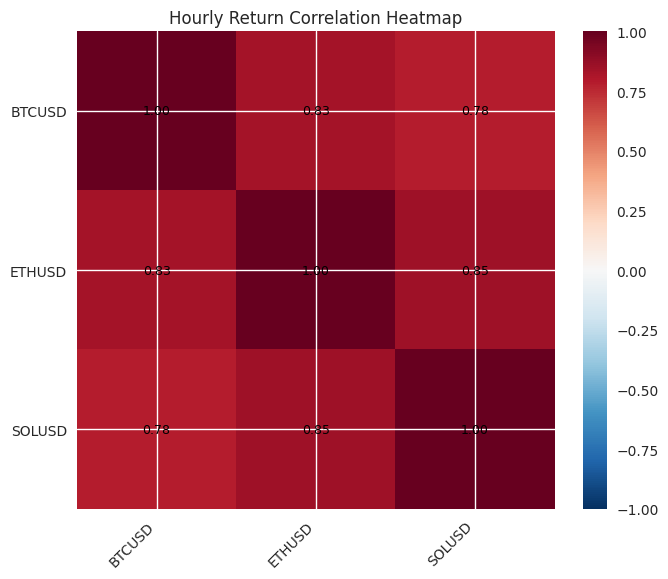

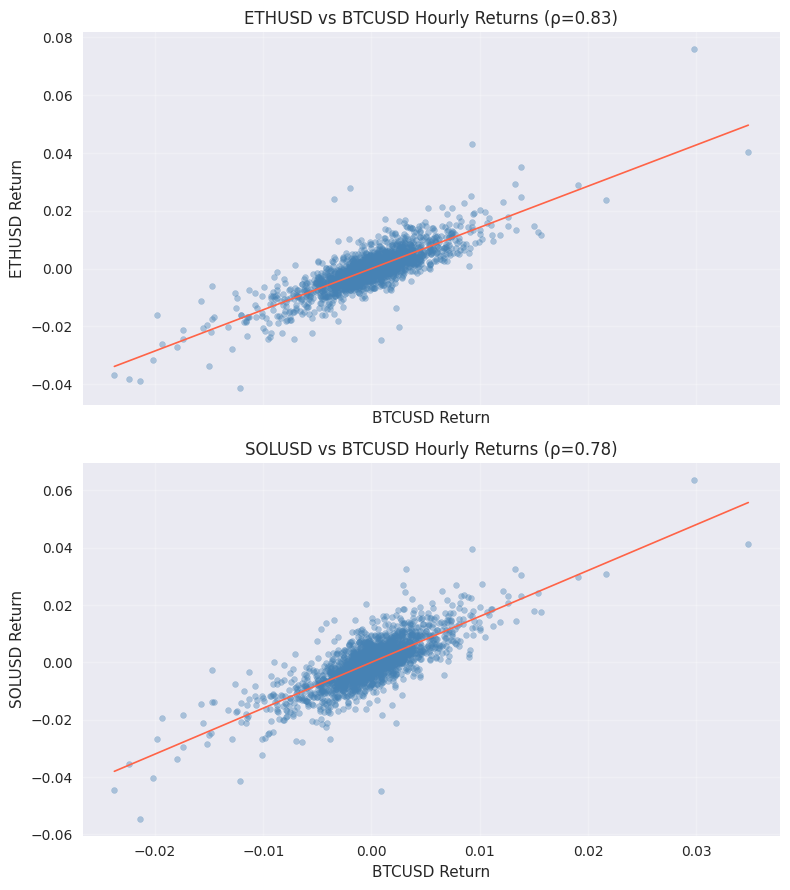

In [80]:
VISUALIZE_CROSS_SECTION = True
CORR_LOOKBACK = timedelta(days=90)

if VISUALIZE_CROSS_SECTION:
    history = qb.History(PLOT_SYMBOLS, CORR_LOOKBACK, DEFAULT_RESOLUTION)
    if history.empty:
        raise ValueError("History request returned empty frame. Check data permissions or timeframe.")

    closes = history.close.unstack(level=0).tz_localize(None)
    returns = closes.pct_change().dropna()

    corr_matrix = returns.corr()

    fig, ax = plt.subplots(figsize=(6 + len(PLOT_SYMBOLS) * 0.6, 5 + len(PLOT_SYMBOLS) * 0.3))
    im = ax.imshow(corr_matrix, vmin=-1, vmax=1, cmap='RdBu_r')
    ax.set_xticks(range(len(corr_matrix.columns)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
    ax.set_yticks(range(len(corr_matrix.index)))
    ax.set_yticklabels(corr_matrix.index)
    ax.set_title('Hourly Return Correlation Heatmap')
    for i in range(len(corr_matrix.index)):
        for j in range(len(corr_matrix.columns)):
            ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black', fontsize=9)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.show()

    if len(PLOT_SYMBOLS) > 1:
        base_symbol = PLOT_SYMBOLS[0]
        base_key = base_symbol.Value
        base_returns = returns[base_key]
        other_symbols = PLOT_SYMBOLS[1:]

        fig, axes = plt.subplots(len(other_symbols), 1, figsize=(8, 4.5 * len(other_symbols)), sharex=True)
        if len(other_symbols) == 1:
            axes = [axes]

        for ax, symbol in zip(axes, other_symbols):
            symbol_key = symbol.Value
            data = returns[[base_key, symbol_key]].dropna()
            ax.scatter(data[base_key], data[symbol_key], alpha=0.4, s=18, color='steelblue')
            coeff = np.polyfit(data[base_key], data[symbol_key], 1)
            fit_line = np.poly1d(coeff)
            xs = np.linspace(data[base_key].min(), data[base_key].max(), 100)
            ax.plot(xs, fit_line(xs), color='tomato', linewidth=1.2)
            ax.set_title(f"{symbol_key} vs {base_key} Hourly Returns (ρ={data.corr().iloc[0, 1]:.2f})")
            ax.set_xlabel(f"{base_key} Return")
            ax.set_ylabel(f"{symbol_key} Return")
            ax.grid(alpha=0.25)

        fig.tight_layout()
        plt.show()



### How to Read the Visuals
- **Price & Volume**: Left axis plots close prices; right axis overlays volume bars. Look for price thrusts backed by rising volume and note venues/dates with drying liquidity.
- **Momentum & Relative Volume**: Left panel overlays multi-horizon rate-of-change on price; right panel tracks relative volume vs. a rolling baseline. Sustained ROC above zero with rVOL > 1 signals supportive flows; sharp reversals without volume confirm fade setups.
- **Return Distributions**: Histograms show the distribution of hourly returns with the mean marked in red. Skew/tails hint at breakout regimes vs. choppy mean-reversion environments and help calibrate risk budgets.
- **Volatility & Drawdown Diagnostics**: Realized-vol curves vs. ATR% reveal regime transitions (expanding/tightening ranges); drawdown panels show how deep we’ve dipped relative to recent peaks for sizing and stop placement.
- **Cross-Asset Structure**: Correlation heatmaps and scatter plots highlight clustering, contagion risk, and diversification pockets—useful when constructing baskets or throttling overlapping bets.
- **On-Chain Activity**: Active addresses, netflows, and whale transactions confirm whether blockchain participation supports price moves or signals rotation risk.
- **Funding & Derivatives**: Funding-rate flips, OI builds, and basis trends expose leverage stress points and crowded trades that can accelerate breakouts or liquidations.
- **Sentiment & Attention**: Social dominance, polarity, and mention velocity indicate whether the crowd is amplifying or fading the move; divergence vs. price often marks exhaustion.
- **DeFi & Liquidity**: TVL migration and on-chain rates reveal where liquidity is rotating; collapsing TVL or rising borrow costs can undercut otherwise strong momentum.
- **Tokenomics & Events**: Upcoming unlocks/burns/governance votes flag supply shocks or catalysts and help schedule entries/exits.
- **Execution Analytics**: Slippage, latency, and fill-rate diagnostics guide venue selection, sizing, and kill-switch thresholds before deploying live capital.


In [81]:
RUN_SAMPLE_HISTORY = False

if RUN_SAMPLE_HISTORY:
    lookback = timedelta(days=90)
    history = qb.History(SYMBOLS, lookback, DEFAULT_RESOLUTION)
    price_panel = (
        history.close.unstack(level=0)
        .tz_localize(None)
        .ffill()
    )
    price_panel.tail()
